In [17]:
import tensorflow as tf
import numpy as np
import os
import time

### SOURCE TEXT LOADING
- loading .txt
- printing the beginning, number of characters, number of unique characters
    

In [18]:
with open("/tf/tensorflow-tutorials/ring.txt", "r") as f:
    source = f.read()
print(source[:300])

THE  FELLOWSHIP 
OF  THE  RING 


BEING  THE  FIRST  PART 
OF 

The  Lord  of  the  Rings 


BOOK  ONE 


Chapter  I 


A  LONG-EXPECTED  PARTY 


When  Mr.  Bilbo  Baggins  of  Bag  End  announced  that  he 
would  shortly  be  celebrating  his  eleventy-first  birthday  with 
a  party  of  special


In [19]:
print ('{} characters'.format(len(source)))

1145534 characters


In [20]:
vocab = sorted(set(source))
print ('{} unique characters'.format(len(vocab)))

88 unique characters


In [21]:
# unique characters to indices mapping
char2index = {u:i for i, u in enumerate(vocab)}
index2char = np.array(vocab)

text_as_int = np.array([char2index[c] for c in source])

print(text_as_int)

[45 33 30 ...  1  0  0]


In [22]:
print ('{} -- characters mapped to int -- > {}'.format(repr(source[:13]), text_as_int[:13]))

'THE  FELLOWSH' -- characters mapped to int -- > [45 33 30  1  1 31 30 37 37 40 48 44 33]


### DATASET PREPROCESSING
- character to index mapping and converting text to numerical representation
- defining max input sequence length
- creating TensorFlow Dataset from the source
- creating batches from dataset
- input-target split function (:-1 is input, and last element is expected value)
- applying input-target split function to each batch

In [23]:
seq_length = 100
examples_per_epoch = len(source)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(index2char[i.numpy()])


T
H
E
 
 


2024-12-28 22:28:27.331969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [1145534]
	 [[{{node Placeholder/_0}}]]


In [24]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(index2char[item.numpy()])))

'THE  FELLOWSHIP \nOF  THE  RING \n\n\nBEING  THE  FIRST  PART \nOF \n\nThe  Lord  of  the  Rings \n\n\nBOOK  ON'
'E \n\n\nChapter  I \n\n\nA  LONG-EXPECTED  PARTY \n\n\nWhen  Mr.  Bilbo  Baggins  of  Bag  End  announced  tha'
't  he \nwould  shortly  be  celebrating  his  eleventy-first  birthday  with \na  party  of  special  m'
'agnificence,  there  was  much  talk  and \nexcitement  in  Hobbiton. \n\nBilbo  was  very  rich  and  v'
'ery  peculiar,  and  had  been  the \nwonder  of  the  Shire  for  sixty  years,  ever  since  his  re'


2024-12-28 22:28:27.495947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [1145534]
	 [[{{node Placeholder/_0}}]]


In [25]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

### PARAMETERS
- training parameters & data shuffling
- model hyperparameters

In [26]:
BATCH_SIZE = 2048
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(2048, 100), dtype=tf.int64, name=None), TensorSpec(shape=(2048, 100), dtype=tf.int64, name=None))>

In [27]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 300 #256

# Number of RNN units
rnn_units1 = 256
rnn_units2 = 256
rnn_units=[rnn_units1, rnn_units2]
print(vocab_size)

88


### BUILDING MODEL
- GRU, LSTM, RNN, with Conv1

In [30]:
# RNN
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.SimpleRNN(rnn_units1,
                                  return_sequences=True,
                                  stateful=True,
                                  recurrent_initializer='glorot_uniform'),
        tf.keras.layers.SimpleRNN(rnn_units2,
                                  return_sequences=True,
                                  stateful=True,
                                  recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model


In [32]:
model = build_model(
  vocab_size = vocab_size,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (2048, None, 300)         26400     
                                                                 
 simple_rnn (SimpleRNN)      (2048, None, 256)         142592    
                                                                 
 simple_rnn_1 (SimpleRNN)    (2048, None, 256)         131328    
                                                                 
 dense (Dense)               (2048, None, 88)          22616     
                                                                 
Total params: 322,936
Trainable params: 322,936
Non-trainable params: 0
_________________________________________________________________


### MODEL TRAINING
- optimizer & loss function declaration
- compilation
- epochs number
- launching the training

In [34]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [35]:
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [36]:
checkpoint_dir = './checkpoints_RNN_ring_v1'        # TODO: remember to choose proper directory
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [37]:
EPOCHS=200

In [38]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/200


2024-12-28 22:28:30.698977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [1145534]
	 [[{{node Placeholder/_0}}]]
2024-12-28 22:28:30.699300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [1145534]
	 [[{{node Placeholder/_0}}]]
2024-12-28 22:28:35.811512: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7faf6ca319e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-28 22:28:35.811576: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA G

5/5 [==============================] - 11s 986ms/step - loss: 4.1322 - accuracy: 0.1350
Epoch 2/200
5/5 [==============================] - 7s 981ms/step - loss: 3.0594 - accuracy: 0.3009
Epoch 3/200
5/5 [==============================] - 6s 684ms/step - loss: 2.8801 - accuracy: 0.3007
Epoch 4/200
5/5 [==============================] - 6s 819ms/step - loss: 2.8083 - accuracy: 0.3009
Epoch 5/200
5/5 [==============================] - 6s 677ms/step - loss: 2.7173 - accuracy: 0.3169
Epoch 6/200
5/5 [==============================] - 5s 625ms/step - loss: 2.6274 - accuracy: 0.3317
Epoch 7/200
5/5 [==============================] - 5s 637ms/step - loss: 2.5357 - accuracy: 0.3552
Epoch 8/200
5/5 [==============================] - 6s 599ms/step - loss: 2.4641 - accuracy: 0.3648
Epoch 9/200
5/5 [==============================] - 6s 738ms/step - loss: 2.3996 - accuracy: 0.3714
Epoch 10/200
5/5 [==============================] - 6s 649ms/step - loss: 2.3409 - accuracy: 0.3900
Epoch 11/200
5/5 [==

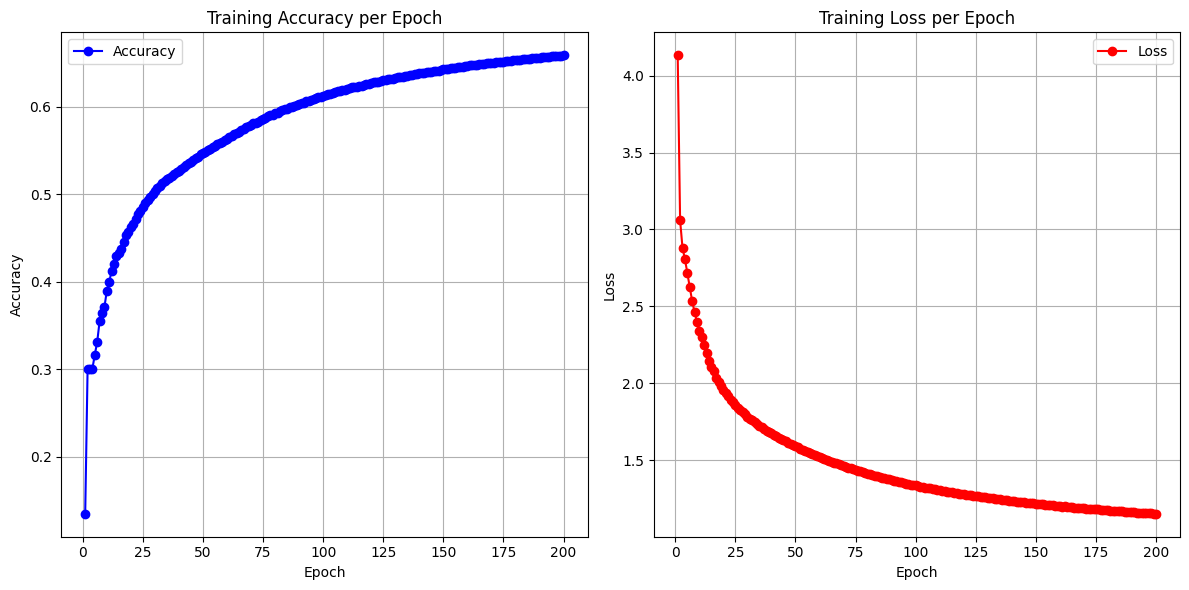

In [39]:
import matplotlib.pyplot as plt

# Pobranie wartości strat i dokładności z historii
loss = history.history['loss']
accuracy = history.history['accuracy']
epochs = range(1, len(loss) + 1)

# Wykres strat i dokładności
plt.figure(figsize=(12, 6))

# Wykres strat
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', label='Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### RESULTS
- bulding the model and applying saved weights
- text generation function
- generate text based on the provided beginning

In [40]:
latest_check= tf.train.latest_checkpoint(checkpoint_dir)

In [41]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(latest_check)

model.build(tf.TensorShape([1, None]))

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 300)            26400     
                                                                 
 simple_rnn_2 (SimpleRNN)    (1, None, 256)            142592    
                                                                 
 simple_rnn_3 (SimpleRNN)    (1, None, 256)            131328    
                                                                 
 dense_1 (Dense)             (1, None, 88)             22616     
                                                                 
Total params: 322,936
Trainable params: 322,936
Non-trainable params: 0
_________________________________________________________________


In [43]:
def generate_text(model, start_string):

  num_generate = 1000
  input_eval = [char2index[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  scaling = 0.5

  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predictions = predictions / scaling
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(index2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [52]:
print(generate_text(model, start_string=u"Harry killed Ron "))

Harry killed Ron  she  said,  and  the  others  that  he  was  road  suddenly  of  the  remained  by  the  water.  They  came  to  the  mountains  and  all  the  light  of  the  house  of  the  wise  in  the  since  that  he  would  not  come  to  himself  and  decided  to  the  look  along  the  land  of  the  dark,  and  the  top  of  the  Nine 


207 


The  boats  to  the  Ring  to  see  a  silver 
than  the  sky  and  stood  of  the  far  our  dark  and  slain  of  the  bank,  recard  the  stream  seemed  to  the  gate.  They  could  see  a  word  of  the  dece  like  a  secret  and  become  of  the  hills  were  understand  it  was  a  corner  of  the  flowers  of  course  which  has  not  looked  at  last  the  end  of  the  Enemy  has  still  be  would  not  places  the  world  was  darkness  of  the  river  and  part  that  the  left  and  all  the  corners  of  the  Shire  was  a  long  the  long  and  walking  the  worder  was  green  and  bedrang  to  the  wood  was  a  hob

In [53]:
print(generate_text(model, start_string=u"Bilbo killed Gandalf "))

Bilbo killed Gandalf  that  dell  the  others  starting  the  land. 

‘And  I  should  say.  ‘It  was  a  country  found  at  the  windows.  The  morning  light  and  the  hobbits  road  to  have  to  the  stream  about  them  one  of  the  deep  round  the  path  of  the  riverlabe  where  he  could  not  long  ago  they  will  be  seen  the  land  that  was  the  south  of  the  road  not  meet  him  to  to  leave  Sam  slapped  them  to  see  the  way  of  the  Company 
a  rolled  a  last  seemed  to  be  in  the  news  of  the  Elves  far  a  great  chance  of  the  wind  came  to  the  mountains  and  the  day  they  could  be  great  the  stars  of  the  water  and  the  right  he  was  too  much  the  mountains  and  stake  the  trees  settered  stood  and  stood  towards  the  great  close  to  me  think,  and  a  great  steep  days  were  now  behind  the  road  of  the  sturned  the  song  of  the  stars  a  slowly  the  pony  and  good  and  going  behind  them  away.  I  sa

In [45]:
print(generate_text(model, start_string=u"Manchaster Uniter just lost the war on Anfield fighting"))

Manchaster Uniter just lost the war on Anfield fighting  the  water.  ‘I  will  not  leave  them  and  the  windows  that  he  was  one  that  the  Ring  was  like  the  sun  had  been  last  they  rode  of  the  Sun’s  shining  soft  and  the  windows.  When  they  say  to  be  doubt  at  the  water  and  bore 
and  passing  at  the  worses  of  the  water  grew  starting  to  him,  and  a  great  land 
to  do  worrow  that  he  heard  of  the  hills  behind  them  to  feel  that  he  was  a  shadow  of  the  Ring  to  discrassed  out  of  the  hills,  and  were  master  in  the  sun  the  trees  of  which  was  not  be  a  speak  was  still  to  the  chill  and  the  stream  was  broken  the  Elves  of  the  Bridge  and  the  land  of  the  land  of  the  wind  waters  and  a  large  into  the  day,  and  going  them  and  went  to 
clear  to  the  Company  was  a  little  world  he  spoke  of  merry  and  slowly  he  was  put  it,  and  in  the  ready  to  the  hobbits  would  not  

---

Manchaster Uniter just lost the war on Anfield fighting  the  water.  ‘I  will  not  leave  them  and  the  windows  that  he  was  one  that  the  Ring  was  like  the  sun  had  been  last  they  rode  of  the  Sun’s  shining  soft  and  the  windows.  When  they  say  to  be  doubt  at  the  water  and  bore 
and  passing  at  the  worses  of  the  water  grew  starting  to  him,  and  a  great  land 
to  do  worrow  that  he  heard  of  the  hills  behind  them  to  feel  that  he  was  a  shadow  of  the  Ring  to  discrassed  out  of  the  hills,  and  were  master  in  the  sun  the  trees  of  which  was  not  be  a  speak  was  still  to  the  chill  and  the  stream  was  broken  the  Elves  of  the  Bridge  and  the  land  of  the  land  of  the  wind  waters  and  a  large  into  the  day,  and  going  them  and  went  to 
clear  to  the  Company  was  a  little  world  he  spoke  of  merry  and  slowly  he  was  put  it,  and  in  the  ready  to  the  hobbits  would  not  see  the  trees  shall  fell  that  she  leave  the  gr

In [46]:
def calculate_cross_entropy_loss(model, test_sequences):
    total_loss = 0
    total_steps = 0
    
    for sequence in test_sequences:
        input_seq = sequence[:-1]
        target_seq = sequence[1:]
        
        input_seq = tf.expand_dims(input_seq, 0)
        
        predictions = model(input_seq)
        
        loss = tf.keras.losses.sparse_categorical_crossentropy(target_seq, predictions[0], from_logits=True)
        
        total_loss += tf.reduce_sum(loss).numpy()
        total_steps += len(target_seq)
    
    avg_loss = total_loss / total_steps
    return avg_loss

In [47]:
# tutaj można załadować inną część tolkiena albo hobbita
first_10_sequences = list(sequences.take(2))

2024-12-28 22:50:55.191705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [1145534]
	 [[{{node Placeholder/_0}}]]


In [48]:
avg_loss = calculate_cross_entropy_loss(model, first_10_sequences)
avg_loss

1.1650308609008788

In [49]:
perplexity = np.exp(avg_loss)
perplexity

3.206021822397807

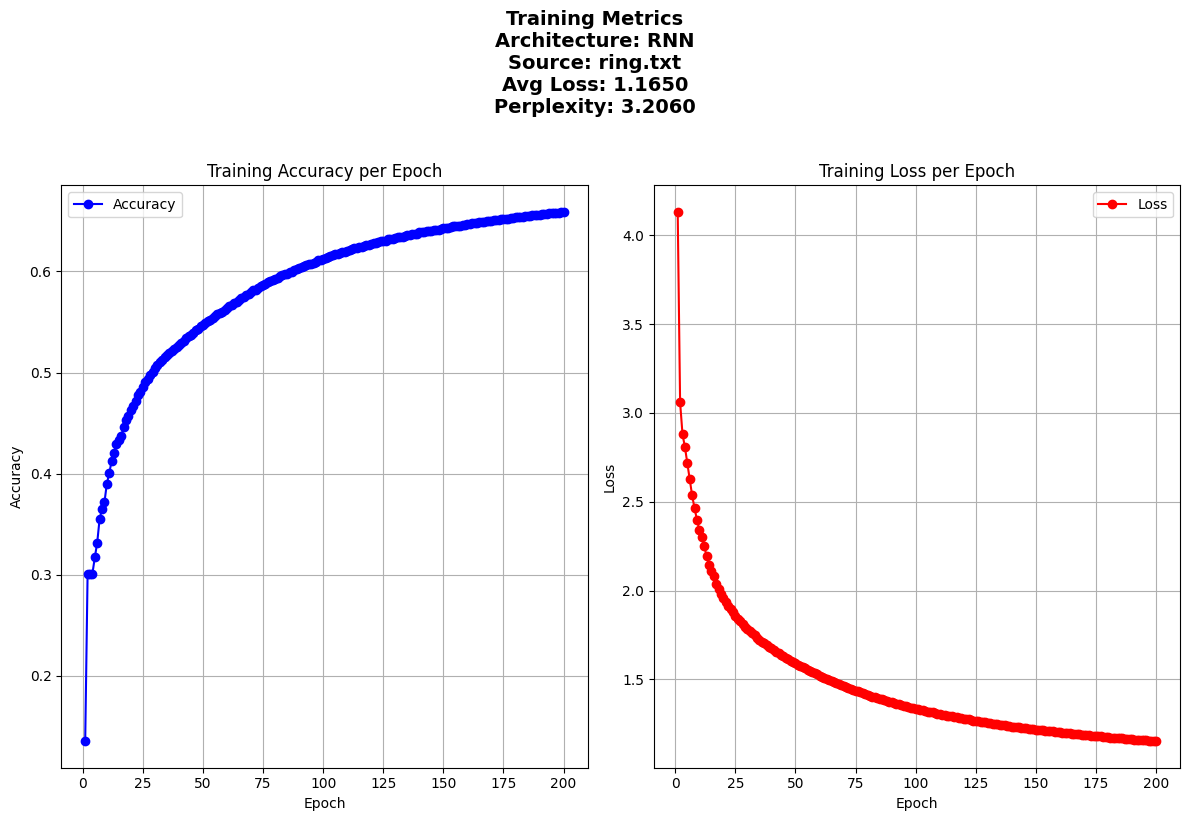

In [50]:
import matplotlib.pyplot as plt

# Pobranie wartości strat i dokładności z historii
loss = history.history['loss']
accuracy = history.history['accuracy']
epochs = range(1, len(loss) + 1)

# Informacje do wyświetlenia
architecture = "RNN"
source_text = "ring.txt"
info_text = f"Architecture: {architecture}\nSource: {source_text}\nAvg Loss: {avg_loss:.4f}\nPerplexity: {perplexity:.4f}"

# Wykres strat i dokładności
plt.figure(figsize=(12, 8))

# Tytuł wykresu z informacjami
plt.suptitle(f"Training Metrics\n{info_text}", fontsize=14, fontweight='bold', y=1.02)

# Wykres dokładności
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Wykres strat
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', label='Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()


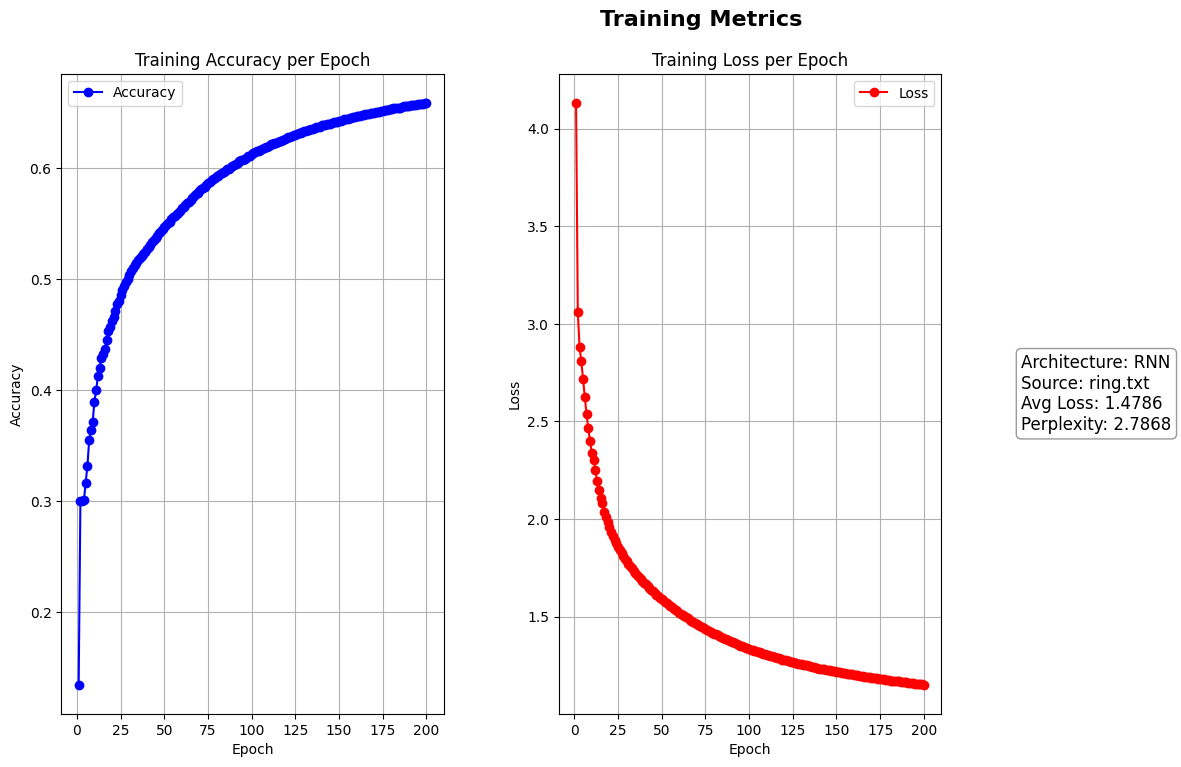

In [51]:
import matplotlib.pyplot as plt

# Pobranie wartości strat i dokładności z historii
loss = history.history['loss']
accuracy = history.history['accuracy']
epochs = range(1, len(loss) + 1)

# Informacje do wyświetlenia
architecture = "RNN"
source_text = "ring.txt"
avg_loss = sum(loss) / len(loss)  # Średnia strat
perplexity = 2 ** avg_loss  # Przykład obliczenia perplexity
info_text = f"Architecture: {architecture}\nSource: {source_text}\nAvg Loss: {avg_loss:.4f}\nPerplexity: {perplexity:.4f}"

# Tworzenie figury i wykresów
fig, axes = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.3})

# Tytuł na środku
fig.suptitle("Training Metrics", fontsize=16, fontweight='bold')

# Wykres dokładności
axes[0].plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
axes[0].set_title('Training Accuracy per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)
axes[0].legend()

# Wykres strat
axes[1].plot(epochs, loss, marker='o', label='Loss', color='red')
axes[1].set_title('Training Loss per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True)
axes[1].legend()

# Dodanie informacji w pustej przestrzeni (poza wykresami)
fig.text(0.7, 0.5, info_text, fontsize=12, va='center', ha='left',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle="round"))

# Dostosowanie marginesów, aby uniknąć nachodzenia
plt.subplots_adjust(left=0.1, right=0.65, top=0.9, bottom=0.1)

# Wyświetlanie wykresu
plt.show()
